# Getting started with ODE Test Problems

## About this notebook

This Jupyter notebook is configured to run [Octave](https://octave.org/) commands. You can confirm the active kernel from the `Kernel` menu by clicking `Change Kernel` and selecting `Octave` form the list.

If you are missing the Octave kernel, please refer to this [readme](readme.md) file and follow the instructions there. 


## Running code cells

Press `Shift + Enter` To run each cell and go the next. 
Le'ts check out the latest version of `ODE Test Problems (OTP)` from its [Github repository](https://github.com/ComputationalScienceLaboratory/ODE-Test-Problems.git) and add the package to the path:

In [2]:
addpath(genpath('../../ODE-Test-Problems'))

## Lorenz63 test problem 

The Lorenz63 test problem, introduced by mathematician Edward Lorenz in 1963 to study the behavior of a simple system of differential equations, is a classic problem in chaos theory. It consists of three ordinary differential equations that describe the behavior of a simplified atmospheric convection system. The following are the equations:

\begin{align}
\frac{dx}{dt} &= σ(y - x), \\
\frac{dy}{dt} &= x(ρ - z) - y, \\
\frac{dz}{dt} &= xy - βz.
\end{align}
where $x$, $y$, and $z$ are variables that represent the state of the system at a given time, and σ, ρ, and β are parameters that control the behavior of the system.


Let's create the Lorenz63 problem and solve it using the default parameters and intial conditions:









    axes at line 107 column 8
    internalPlotPhaseSpace at line 186 column 16
    plotPhaseSpace at line 110 column 17



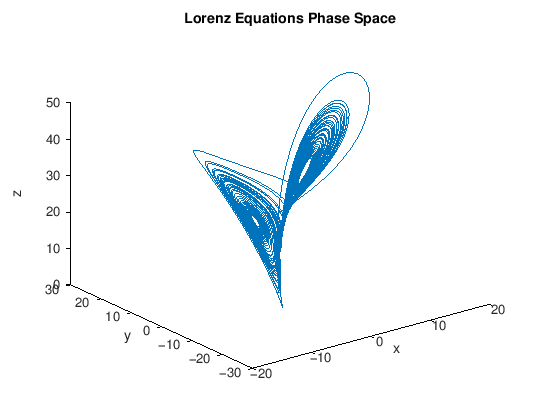

In [3]:
% Create a problem object
problem = otp.lorenz63.presets.Canonical;

% Solve the problem
sol = problem.solve('RelTol', 1e-10);

% Plot the solution
problem.plotPhaseSpace(sol);

The `problem` object contains a number of useful properties including:

* `Name`: The name of the problem
* `NumVars`: Number of variables in the state vector
* `Parameters`: Vector of problem-specific parameters that can be modified 
* `RHS` : The Right-hand-side structure inlcludes the ODE right-hand-side function and possibly Jacobians, splittings, etc. (depending on the test problem)
* `TimeSpan`: Timespan of the integration
* `Y0`: Initial condition 


## Changing the parameters of a problem

The parameters of a model are stored as properties in the problem object:

In [4]:
problem = otp.kpr.presets.Canonical;
problem.Parameters



ans =

  otp.kpr.KPRParameters object with properties:

      Lambda: [2x2 double]
       Omega: [1x1 double]



You can directly change parameters and solve the mdodel again:

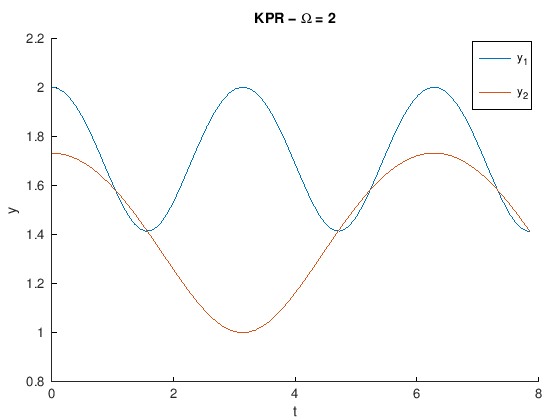

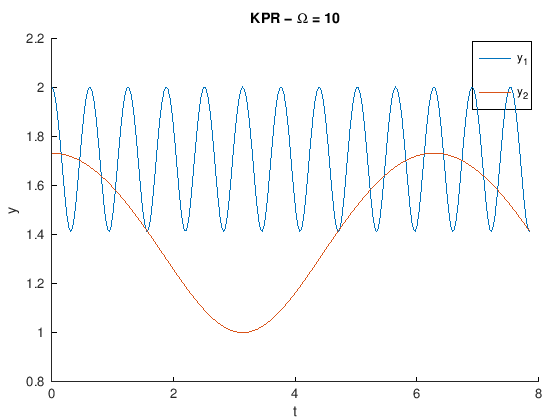

In [5]:
problem.Parameters.Omega = 10;
sol1 =  problem.solve();

problem.Parameters.Omega = 2;
sol2 = problem.solve();

problem.plot(sol1), title('KPR - \Omega = 10')
problem.plot(sol2), title('KPR - \Omega = 2')

## Plotting solutions 

`OTP` has built-in plotting capabilities for visualizing the computed problem solution.  For small problems it is possible to plot the solution trajectory using the `plot` function. 

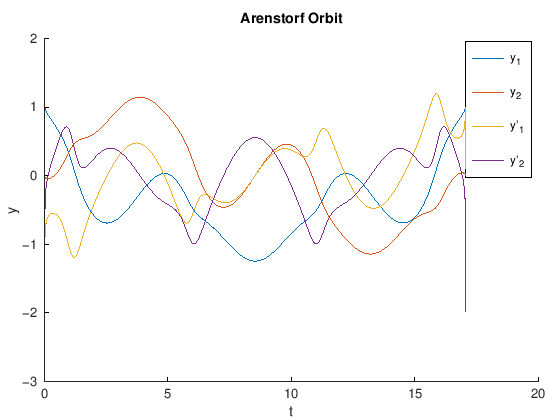

In [6]:
# Create the Arenstorf orbit problem
problem = otp.arenstorf.presets.Canonical;

# Compute the solution
sol = problem.solve('RelTol', 1e-10);

# Create solution plot
problem.plot(sol)

The `plotPhaseSpace ` function creates a phase-space diagram by visualizing all spatial-components of the state vector:

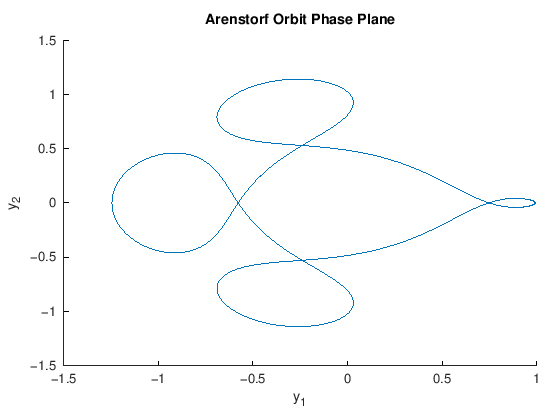

In [7]:
problem.plotPhaseSpace(sol)

## Exploring presets 

Each test problem comes with a number of `presets` that feature different characterstics in the solution of the initial value problem. As an example, The `Brusselator` test problem has *decaying, spiral, and  periodic* `presets`:

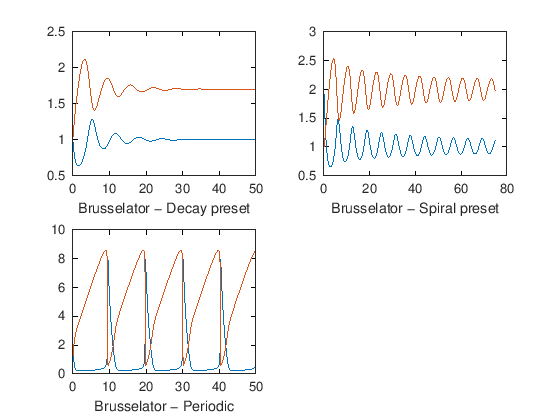

In [8]:
subplot(2,2,1);
problem = otp.brusselator.presets.Decay();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Decay preset')

subplot(2,2,2);
problem = otp.brusselator.presets.Spiral();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Spiral preset')

subplot(2,2,3);
problem = otp.brusselator.presets.Periodic();
sol = problem.solve('RelTol', 1e-6);
plot(sol.x, sol.y)
xlabel('Brusselator - Periodic')

## Changing the solver

The choice of ODE solver for the test problems is flexible. Here, we will use the *Explicit* time-stepping method `ode45` to solve the `Robertson` problem:

In [9]:
% Create a problem object
problem          = otp.robertson.presets.Canonical();
problem.TimeSpan = [0,5];

We will pass the right-hand-side function, timespan of the integration, and the initial condition to `ode45`:

In [10]:
tic
sol = ode45(problem.RHS.F, problem.TimeSpan, problem.Y0);
toc

Elapsed time is 4.41529 seconds.


Since this is a stiff problem, the explicit solver takes a long time to finish the integration. For a faster result, we can use the *Implicit* ODE solver `ode23s` and provide it with the Jacobian of the right-hand-side: 

In [11]:
tic
sol = ode23s(problem.RHS.F, problem.TimeSpan, problem.Y0, odeset('Jacobian', problem.RHS.Jacobian));
toc

Elapsed time is 1.07936 seconds.


## PDE example

We will consider the Allen Cahn equation for this example. This equation describes the evolution of a material undergoing phase separation and pattern formation in a two-dimensional domain.

In [45]:
model          = otp.allencahn.presets.Canonical();
model.TimeSpan = [0,1];
sol            = model.solve('RelTol', 1e-5);

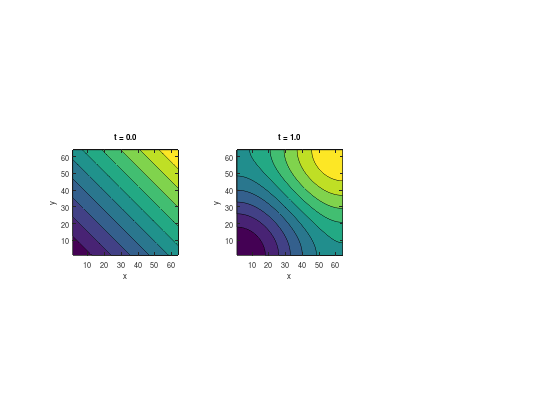

In [51]:
dim_x = sqrt(model.NumVars);

subplot(131); contourf(reshape(sol.y(:,1) , dim_x, []), 10)
axis('equal'); title(sprintf( 't = %1.1f', sol.x(1)));  xlabel('x'); ylabel('y')


subplot(132); contourf(reshape(sol.y(:,end), dim_x, []), 10)
axis('equal'); title(sprintf( 't = %1.1f' , sol.x(end)));  xlabel('x'); ylabel('y')


Many problems in `OTP` include the Jacobian of the right-hand-side function implemented. The Jacobian can be used for implicit time integration, or in PDE-Constrained Optimization solved with Newton-type methods. Let's take a look at the sparsity pattern of the Jacobian for this 2D problem:

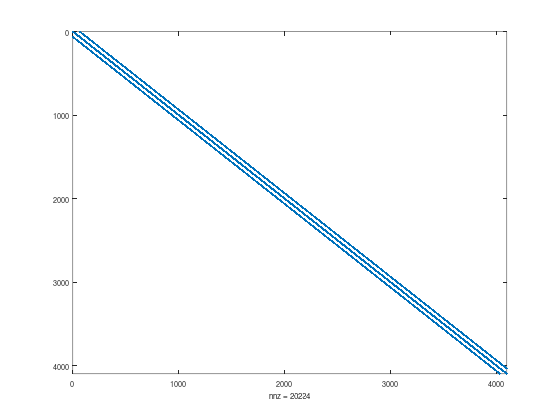

In [56]:
spy(model.RHS.Jacobian(0, model.Y0))

We can see from the banded structure of the Jacobian that this equation is descretized using finite differences. There are a number of utility methods in `otp.utils.pde` that can help with creting discretizations for different partial derivatives

### Building PDE operators

Let's create a 1D derivative operator with Dirichlet boundary conditions in the domain $[0,\pi] $

In [58]:
domain     = [0, pi];
dimensions = 1;
BC         = 'D';
NPoints    = 50;

Dx = otp.utils.pde.Dd(NPoints, domain, 1, dimensions, BC);

We can test this derivatie on the `sin` function:

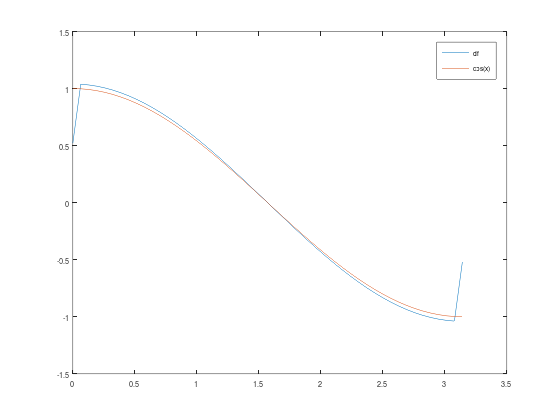

In [67]:
x  = linspace(0,pi,NPoints)';
f  = sin(x);
df = Dx*f;
plot(x,df); hold on; plot(x,cos(x)); legend('df', 'cos(x)')

## List of ODE Test Problems

You can use any of the problems using the template command

`model = otp.{problem name}.presets.{Preset name};`

For a list of implemented test problems in `OTP` please refer to the documentation. 

# Getting help and Contributing

`ODE Test Problems` documentation is maintained on [this github page](https://computationalsciencelaboratory.github.io/ODE-Test-Problems).  

If there is a feature, bug or a new test problem you would like to be added to `OTP`, we encourage you to get in touch with us using a
[GitHub issue](https://github.com/ComputationalScienceLaboratory/ODE-Test-Problems/issues).
We also accept pull requests that adhere to our
[contributing guide](../CONTRIBUTING.md).

A discussion of the main contributions of this open-source package is availabe in our [paper](https://github.com/ComputationalScienceLaboratory/ODE-Test-Problems/blob/master/paper/paper.md). 